In [1]:
# import and parameters
import torch
from torch.autograd import Variable
# load data
from tools import data_loader
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')
from sparse_rrt import _sst_module

seen_N = 1
seen_NP = 1
seen_s = 0
seen_sp = 800
data_folder = './data/acrobot_obs/'
test_data = data_loader.load_test_dataset(seen_N, seen_NP,
                      data_folder, True, seen_s, seen_sp)
obc, obs, paths, sgs, path_lengths, controls, costs = test_data
obs_width = 6.0
step_sz = 0.02
num_steps = 10
dt = 0.02
system = _sst_module.PSOPTAcrobot()
cpp_propagator = _sst_module.SystemPropagator()
propagate_dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
bound = [3.141592653589793, 3.141592653589793, 6.0, 6.0]
def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res


In [2]:
# define dynamics
def dynamics(state, control):
    STATE_THETA_1, STATE_THETA_2, STATE_V_1, STATE_V_2 = 0, 1, 2, 3
    MIN_V_1, MAX_V_1 = -6., 6.
    MIN_V_2, MAX_V_2 = -6., 6.
    MIN_TORQUE, MAX_TORQUE = -4., 4.

    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi

    LENGTH = 20.
    m = 1.0
    lc = 0.5
    lc2 = 0.25
    l2 = 1.
    I1 = 0.2
    I2 = 1.0
    l = 1.0
    g = 9.81

    theta2 = state[STATE_THETA_2]
    theta1 = state[STATE_THETA_1] - np.pi/2
    theta1dot = state[STATE_V_1]
    theta2dot = state[STATE_V_2]
    _tau = control[0]
    m = m
    l2 = l2
    lc2 = lc2
    l = l
    lc = lc
    I1 = I1
    I2 = I2

    d11 = m * lc2 + m * (l2 + lc2 + 2 * l * lc * torch.cos(theta2)) + I1 + I2
    d22 = m * lc2 + I2
    d12 = m * (lc2 + l * lc * torch.cos(theta2)) + I2
    d21 = d12

    c1 = -m * l * lc * theta2dot * theta2dot * torch.sin(theta2) - (2 * m * l * lc * theta1dot * theta2dot * torch.sin(theta2))
    c2 = m * l * lc * theta1dot * theta1dot * torch.sin(theta2)
    g1 = (m * lc + m * l) * g * torch.cos(theta1) + (m * lc * g * torch.cos(theta1 + theta2))
    g2 = m * lc * g * torch.cos(theta1 + theta2)

    #deriv[STATE_THETA_1] = theta1dot
    #deriv[STATE_THETA_2] = theta2dot

    u2 = _tau - 1 * .1 * theta2dot
    u1 = -1 * .1 * theta1dot
    theta1dot_dot = (d22 * (u1 - c1 - g1) - d12 * (u2 - c2 - g2)) / (d11 * d22 - d12 * d21)
    theta2dot_dot = (d11 * (u2 - c2 - g2) - d21 * (u1 - c1 - g1)) / (d11 * d22 - d12 * d21)
    #deriv[STATE_V_1] = theta1dot_dot
    #deriv[STATE_V_2] = theta2dot_dot
    deriv = torch.stack([theta1dot, theta2dot, theta1dot_dot, theta2dot_dot], 0)
    return deriv

def torch_enforce_state_bounds(state):
    STATE_THETA_1, STATE_THETA_2, STATE_V_1, STATE_V_2 = 0, 1, 2, 3
    MIN_V_1, MAX_V_1 = -6., 6.
    MIN_V_2, MAX_V_2 = -6., 6.
    MIN_TORQUE, MAX_TORQUE = -4., 4.

    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    state=torch.empty(4, requires_grad=False)
    if state[0] < -np.pi:
        state[0] += 2*np.pi
    elif state[0] > np.pi:
        state[0] -= 2 * np.pi
    if state[1] < -np.pi:
        state[1] += 2*np.pi
    elif state[1] > np.pi:
        state[1] -= 2 * np.pi

    if state[2] < MIN_V_1:
        state[2] = MIN_V_1
    if state[2] > MAX_V_1:
        state[2] = MAX_V_1
    if state[3] < MIN_V_2:
        state[3] = MIN_V_2
    if state[3] > MAX_V_2:
        state[3] = MAX_V_2
    
    return state

def torch_enforce_control_bounds(control):
    MIN_TORQUE, MAX_TORQUE = -4., 4.
    control = torch.empty(1, requires_grad=False)
    if control[0] < MIN_TORQUE:
        control[0] = MIN_TORQUE
    if control[0] > MAX_TORQUE:
        control[0] = MAX_TORQUE
    return control

    
def enforce_state_bounds(state):
    STATE_THETA_1, STATE_THETA_2, STATE_V_1, STATE_V_2 = 0, 1, 2, 3
    MIN_V_1, MAX_V_1 = -6., 6.
    MIN_V_2, MAX_V_2 = -6., 6.
    MIN_TORQUE, MAX_TORQUE = -4., 4.

    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    
    if state[0] < -np.pi:
        state[0] += 2*np.pi
    elif state[0] > np.pi:
        state[0] -= 2 * np.pi
    if state[1] < -np.pi:
        state[1] += 2*np.pi
    elif state[1] > np.pi:
        state[1] -= 2 * np.pi

    if state[2] < MIN_V_1:
        state[2] = MIN_V_1
    if state[2] > MAX_V_1:
        state[2] = MAX_V_1
    if state[3] < MIN_V_2:
        state[3] = MIN_V_2
    if state[3] > MAX_V_2:
        state[3] = MAX_V_2
    
    return state

def enforce_control_bounds(control):
    MIN_TORQUE, MAX_TORQUE = -4., 4.
    if control[0] < MIN_TORQUE:
        control[0] = MIN_TORQUE
    if control[0] > MAX_TORQUE:
        control[0] = MAX_TORQUE
    return control

    

def IsInCollision(x, obc, obc_width=6.):
    STATE_THETA_1, STATE_THETA_2, STATE_V_1, STATE_V_2 = 0, 1, 2, 3
    MIN_V_1, MAX_V_1 = -6., 6.
    MIN_V_2, MAX_V_2 = -6., 6.
    MIN_TORQUE, MAX_TORQUE = -4., 4.

    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi

    LENGTH = 20.
    m = 1.0
    lc = 0.5
    lc2 = 0.25
    l2 = 1.
    I1 = 0.2
    I2 = 1.0
    l = 1.0
    g = 9.81
    pole_x0 = 0.
    pole_y0 = 0.
    pole_x1 = LENGTH * np.cos(x[STATE_THETA_1] - np.pi / 2)
    pole_y1 = LENGTH * np.sin(x[STATE_THETA_1] - np.pi / 2)
    pole_x2 = pole_x1 + LENGTH * np.cos(x[STATE_THETA_1] + x[STATE_THETA_2] - np.pi / 2)
    pole_y2 = pole_y1 + LENGTH * np.sin(x[STATE_THETA_1] + x[STATE_THETA_2] - np.pi / 2)
    for i in range(len(obc)):
        for j in range(0, 8, 2):
            x1 = obc[i][j]
            y1 = obc[i][j+1]
            x2 = obc[i][(j+2) % 8]
            y2 = obc[i][(j+3) % 8]
            if line_line_cc(pole_x0, pole_y0, pole_x1, pole_y1, x1, y1, x2, y2):
                return True
            if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                return True
    return False

def line_line_cc(x1, y1, x2, y2, x3, y3, x4, y4):
    uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
    uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
    if uA >= 0. and uA <= 1. and uB >= 0. and uB <= 1.:
        # intersection
        return True
    # collision free
    return False

In [3]:
# define the BVP solver
def dynamic_loss(x0, u0, x1, num_dt, dt):
    bound = torch.tensor([3.141592653589793, 3.141592653589793, 6.0, 6.0])
    x_target = x0
    for i in range(num_dt):
        x_target = dynamics(x_target, u0) * dt + x_target
    
    #x_target_norm = x_target / bound
    #x1_norm = x1 / bound  # normalize everything to -1 ~ 1
    #return torch.mean((x_target_norm - x1_norm) ** 2) / 4
    res = x_target - x1
    circular = system.is_circular_topology()

    for i in range(len(x_target)):
        if circular[i]:
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
            if res[i] < -np.pi:
                res[i] = res[i] + 2*np.pi
    #res = (x_target - x1) ** 2
    #res = res ** 2
    res = torch.abs(res)
    res = torch.mean(res)
    #if res <= 1.:
    #    res = res * (1 / res.detach().data.item())
    return res

def bvp_solve_naive(x_init, u_init, dt, num_steps):
    # there are num_steps - 1 intermediate nodes
    #x0 = torch.tensor(start)
    x0 = torch.from_numpy(x_init[0]).cuda()
    #xG = torch.tensor(goal)
    xG = torch.from_numpy(x_init[-1]).cuda()
    xs = torch.from_numpy(x_init)
    us = torch.from_numpy(u_init)

    x0 = Variable(x0, requires_grad=False).cuda().detach()
    xG = Variable(xG, requires_grad=False).cuda().detach()
    
    xs = Variable(xs, requires_grad=True).cuda().detach()
    xs.requires_grad = True
    #xs = [Variable(xs[i], requires_grad=True) for i in range(len(xs))]
    us = Variable(us, requires_grad=True).cuda().detach()
    us.requires_grad = True
    #us = [Variable(us[i], requires_grad=True) for i in range(len(us))]
    #opt_algo = torch.optim.Adagrad
    opt_algo = torch.optim.Adam
    
    opt = opt_algo([xs, us], lr=1e-1)
    
    
    max_iter = 1000
    for opt_iter in range(max_iter):        
        # calcualte the start loss
        l0 = dynamic_loss(x0, us[0], xs[1], 1, dt)
        l_sum = l0
        lts = []
        for t in range(1, len(xs)-2):
            lt = dynamic_loss(xs[t], us[t], xs[t+1], 1, dt)
            l_sum += lt
            lts.append(lt.cpu().item())
        # calculate the goal loss
        lT = dynamic_loss(xs[-2], us[-1], xG, 1, dt)
        l_sum += lT
        #l_sum *= 10000
        # optimize by SGD
        opt.zero_grad()
        xs.retain_grad()
        us.retain_grad()
        l_sum.backward()
        opt.step()
        # enforce bounds on states & controls
        with torch.no_grad():
            for t in range(1,len(xs)-1):
                enforce_state_bounds(xs[t])

            for t in range(len(us)):
                enforce_control_bounds(us[t])
        #print('####################')
        #print('iteration %d: ' % (opt_iter))
        #print('loss: ')
        #print('l_0: ', l0.item())
        #print('lts: ', lts)
        #print('l_T: ', lT.item())
        
        #for t in range(1, len(xs)-1):
        #    #print('l_%d: %f' % (t, lts[t-1].item()))
        #print('l_T: ', lT.item())
        if opt_iter == 0 or opt_iter == max_iter-1:
            print('l_sum: ', l_sum.cpu().item())
            print('l_0: ', l0.cpu().item())
            print('lts: ', lts)
            print('l_T: ', lT.cpu().item())
        #print('####################')
        #print('vars:')
        #print('xs: ')
        #print(xs.detach().data.numpy())
        #print('us: ')
        #print(us.detach().data.numpy())
    
    x0_res = np.array([x0.cpu().data.numpy()])
    xs_res = xs.cpu().detach().data.numpy()[1:-1]
    xT_res = np.array([xG.cpu().data.numpy()])
    us_res = us.cpu().detach().data.numpy()
    
    #print(x0_res.shape)
    #print(xs_res.shape)
    #print(xT_res.shape)
    x_res = np.concatenate([x0_res, xs_res, xT_res], 0)
    u_res = us_res
    return x_res, u_res
        
    
    
    



In [4]:
def bvp_solve(x_init, u_init, dt, num_steps):
    # there are num_steps - 1 intermediate nodes
    #x0 = torch.tensor(start)
    x0 = torch.from_numpy(x_init[0])
    #xG = torch.tensor(goal)
    xG = torch.from_numpy(x_init[-1])
    # random initialize xs
    #xs = torch.linspace(x0, xG, num_steps-1)
    #xs = []
    #for i in range(len(x0)):
    #    xs_i = torch.linspace(x0[i].item(), xG[i].item(), num_steps-1)
    #    xs_i = torch.normal(mean=xs_i, std=0.5)
    #    xs.append(xs_i)
    #xs = torch.from_numpy(x_init)
    #xs = torch.stack(xs, 0).T
    #xs = torch.zeros([num_steps-1, len(start)])  # to optimize
    #us = torch.zeros([num_steps, 1]).uniform_(-4., 4.)  # to optimize
    xs = [torch.from_numpy(x_init[i]) for i in range(len(x_init))]
    #us = torch.from_numpy(u_init)
    us = [torch.from_numpy(u_init[i]) for i in range(len(u_init))]
    x0 = Variable(x0, requires_grad=False)
    xG = Variable(xG, requires_grad=False)
    
    #xs = Variable(xs, requires_grad=True)
    xs = [Variable(xs[i], requires_grad=True) for i in range(len(xs))]
    #us = Variable(us, requires_grad=True)
    us = [Variable(us[i], requires_grad=True) for i in range(len(us))]
    #opt_algo = torch.optim.Adagrad
    opt_algo = torch.optim.SGD
    
    opt0 = opt_algo([us[0]], lr=1e-1)
    opts = [opt_algo([xs[i], us[i]], lr=1e-1) for i in range(1, len(xs)-2)]
    optT = opt_algo([xs[-2], us[-1]], lr=1e-1)
    #opt = opt_algo([xs, us], lr=1e-1)
    max_iter = 100
    for opt_iter in range(max_iter):
        l_sum = 0.
        lT = dynamic_loss(xs[-2], us[-1], xG, 1, dt)
        optT.zero_grad()
        lT.backward()
        optT.step()
        l_sum += lT
        for t in range(len(xs)-3, 0, -1):
            lt = dynamic_loss(xs[t], us[t], xs[t+1], 1, dt)
            opts[t-1].zero_grad()
            lt.backward()
            opts[t-1].step()
            l_sum += lt
            
        # calcualte the start loss
        l0 = dynamic_loss(x0, us[0], xs[1], 1, dt)
        opt0.zero_grad()
        l0.backward()
        opt0.step()
        l_sum += l0
        with torch.no_grad():
            for t in range(1,len(xs)-1):
                #xs[t] = enforce_state_bounds(xs[t])
                enforce_state_bounds(xs[t])
                #W.data.copy(new_value.data)
                #xs[t].data.copy(enforce_state_bounds(xs[t]))
                #xs[t] = xs[t] * 0. + torch_enforce_state_bounds(xs[t])
                #print(xs[t])
            for t in range(len(us)):
                enforce_control_bounds(us[t])
                #us[t] = enforce_control_bounds(us[t])
                #us[t].data.copy(enforce_control_bounds(us[t]))
                #us[t] = us[t] * 0. + torch_enforce_control_bounds(us[t])
                #print(us[t])
        #print('####################')
        #print('iteration %d: ' % (opt_iter))
        #print('loss: ')
        #print('l_0: ', l0.item())
        #for t in range(1, len(xs)-1):
        #    #print('l_%d: %f' % (t, lts[t-1].item()))
        #print('l_T: ', lT.item())
        if opt_iter == 0 or opt_iter == max_iter-1:
            print('l_sum: ', l_sum.item())
        #print('####################')
        #print('vars:')
        #print('xs: ')
        #print(xs.detach().data.numpy())
        #print('us: ')
        #print(us.detach().data.numpy())
    
    x0_res = np.array([x0.data.numpy()])
    xs_res = xs[1:-1]
    xs_res = np.array([xs[i].detach().data.numpy() for i in range(len(xs_res))])
    #xs_res = xs.detach().data.numpy()[1:-1]
    xT_res = np.array([xG.data.numpy()])
    #us_res = us.detach().data.numpy()
    us_res = np.array([us[i].detach().data.numpy() for i in range(len(us))])
    #print(x0_res.shape)
    #print(xs_res.shape)
    #print(xT_res.shape)
    x_res = np.concatenate([x0_res, xs_res, xT_res], 0)
    u_res = us_res
    return x_res, u_res
        

In [5]:
def bvp_solve(x_init, u_init, dt, num_steps):
    # there are num_steps - 1 intermediate nodes
    #x0 = torch.tensor(start)
    x0 = torch.from_numpy(x_init[0])
    #xG = torch.tensor(goal)
    xG = torch.from_numpy(x_init[-1])
    xs = torch.from_numpy(x_init)
    us = torch.from_numpy(u_init)
    x0 = Variable(x0, requires_grad=False)
    xG = Variable(xG, requires_grad=False)
    
    #xs = Variable(xs, requires_grad=True)
    
    #us = Variable(us, requires_grad=True)
    opt_algo = torch.optim.Adam
    circular = system.is_circular_topology()
    max_iter = 50
    lr = 1e-1
    for opt_iter in range(max_iter):
        #*** project from Set B to Set A
        # by propagating using the u
        uA = us.clone().detach()
        uA.requires_grad = True
        #print(uA)
        opt_ba_project = opt_algo([uA], lr=lr)
        print('projection from B to A:')
        for ba_project_i in range(10):
            #print('iteration %d:' % (ba_project_i))
            xA = [x0]
            x = x0
            for i in range(len(us)):
                x = dt * dynamics(x, uA[i]) + x
                xA.append(x)
            xA = torch.stack(xA, 0)
            l_sum = 0.

            for i in range(len(xA)):
                dif = xA[i] - xs[i]
                dif_new = torch.empty(4)
                for j in range(4):
                    if circular[j]:
                        if dif[j] >= np.pi:

                            dif_new[j] = dif[j] - 2*np.pi
                        elif dif[j] <= -np.pi:

                            dif_new[j] = dif[j] + 2*np.pi
                        else:
                            dif_new[j] = dif[j]
                    else:
                        dif_new[j] = dif[j]

                l_sum += torch.sum(dif_new ** 2)
            
            l_sum += torch.sum((uA - us) ** 2)
            l_sum = l_sum / len(xA)
            opt_ba_project.zero_grad()
            l_sum.backward()
            #uA.retain_grad()
            uA.grad.data.clamp_(-4/lr,4/lr)

            opt_ba_project.step()
            #print(uA.grad)
            # enforce bounds for controls
            with torch.no_grad():
                for t in range(len(uA)):
                    enforce_control_bounds(uA[t])
            if ba_project_i == 0 or ba_project_i == 99:
                print('l_sum: ', l_sum.item())
        # enforce bound for results of Set A
        xA = [x0]
        x = x0
        for i in range(len(us)):
            x = dt * dynamics(x, uA[i]) + x
            enforce_state_bounds(x)
            xA.append(x)
        xA = torch.stack(xA)
        #*** project from Set A to Set B (by setting xT=xG)
        #print("xs:")
        #print(xs)
        #print('us:')
        #print(us)
        #print('xA:')
        #print(xA)
        #print('uA:')
        #print(uA)
        xs = xA.detach().data
        xs[-1] = xG
        us = uA.clone().detach()

        
        
    x0_res = np.array([x0.data.numpy()])
    xs_res = xs.data.numpy()[1:-1]
    xT_res = np.array([xG.data.numpy()])
    us_res = us.detach().data.numpy()
    x_res = np.concatenate([x0_res, xs_res, xT_res], 0)
    u_res = us_res
    return x_res, u_res


In [6]:
def dynamic_loss(x0, u0, x1, num_dt, dt):
    bound = torch.tensor([3.141592653589793, 3.141592653589793, 6.0, 6.0])
    x_target = x0
    for i in range(num_dt):
        x_target = dynamics(x_target, u0) * dt + x_target
    
    #x_target_norm = x_target / bound
    #x1_norm = x1 / bound  # normalize everything to -1 ~ 1
    #return torch.mean((x_target_norm - x1_norm) ** 2) / 4
    res = x_target - x1
    circular = system.is_circular_topology()

    for i in range(len(x_target)):
        if circular[i]:
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
            if res[i] < -np.pi:
                res[i] = res[i] + 2*np.pi
    #res = (x_target - x1) ** 2
    #res = res ** 2

    res = torch.abs(res)
    cond = res < 1
    l = torch.where(cond, 0.5 * res ** 2, res)
    #l = torch.mean(l, dim=0)  # sum alone the batch dimension, now the dimension is the same as input dimension

    res = torch.mean(res)
    #if res <= 1.:
    #    res = res * (1 / res.detach().data.item())
    return res

def bvp_solve_naive(x_init, u_init, dt, num_steps):
    # there are num_steps - 1 intermediate nodes
    x0 = torch.from_numpy(x_init[0])
    xG = torch.from_numpy(x_init[-1])
    xs = [torch.from_numpy(x_init[i]) for i in range(len(x_init))]
    us = [torch.from_numpy(u_init[i]) for i in range(len(u_init))]
    x0 = Variable(x0, requires_grad=False)
    xG = Variable(xG, requires_grad=False)
    
    xs = [Variable(xs[i], requires_grad=True) for i in range(len(xs))]
    us = [Variable(us[i], requires_grad=True) for i in range(len(us))]
    
    #us = [Variable(us[i], requires_grad=True) for i in range(len(us))]
    #opt_algo = torch.optim.Adagrad
    opt_algo = torch.optim.Adam
    
    #opt = opt_algo([xs, us], lr=1e-1)
    
    
    max_iter = 20
    for opt_iter in range(max_iter):        
        # forward pass
        with torch.no_grad():
            #for i in range(len(us)-2, -1, -1):
            for i in range(len(us)-1):
                xs[i+1] = dt*dynamics(xs[i], us[i]) + xs[i]
                with torch.no_grad():
                        enforce_state_bounds(xs[i+1])
        # backward pass using loss of endpoint to update u and x
        loss_sum = 0.
        for i in range(len(xs)-2, 0, -1):
            # using next state as a fixed target to optimize current state and control

            xs[i].requires_grad = True
            us[i].requires_grad = True
            opt_i = opt_algo([xs[i], us[i]], lr=1e-2)
            xs[i+1].detach()
            for j in range(5):
                def closure():
                    loss = dynamic_loss(xs[i], us[i], xs[i+1], 1, dt)
                    #print('xs[i]: ', xs[i])
                    #print('us[i]: ', us[i])
                    #print('xs[i+1]: ', xs[i+1])
                    #print('dynamic loss: ', loss)
                    opt_i.zero_grad()
                    loss.backward()

                    return loss
                opt_i.step(closure)
            with torch.no_grad():
                loss = dynamic_loss(xs[i], us[i], xs[i+1], 1, dt)
                loss_sum += loss.item()
                
                enforce_state_bounds(xs[i])
                enforce_control_bounds(us[i])
            #loss_sum += loss.item()
        # handle first state
        us[0].requires_grad = True
        opt_i = opt_algo([x0, us[0]], lr=1e-1)
        xs[1].detach()
        for j in range(10):
            def closure():
                loss = dynamic_loss(x0, us[0], xs[1], 1, dt)
                opt_i.zero_grad()
                loss.backward()
                return loss
            opt_i.step(closure)
        loss = dynamic_loss(x0, us[0], xs[1], 1, dt)
        loss_sum += loss.item()
        print('iteration ', opt_iter)
        print('loss_sum: ', loss_sum)
    x0_res = np.array([x0.data.numpy()])
    xs_res = xs[1:-1]
    xs_res = np.array([xs[i].detach().data.numpy() for i in range(len(xs_res))])
    xT_res = np.array([xG.data.numpy()])
    us_res = np.array([us[i].detach().data.numpy() for i in range(len(us))]) 
    
    #print(x0_res.shape)
    #print(xs_res.shape)
    #print(xT_res.shape)
    x_res = np.concatenate([x0_res, xs_res, xT_res], 0)
    u_res = us_res
    return x_res, u_res
        
    
    

In [7]:
def dynamic_loss(x0, u0, x1, num_dt, dt):
    bound = torch.tensor([3.141592653589793, 3.141592653589793, 6.0, 6.0])
    x_target = x0
    for i in range(num_dt):
        x_target = dynamics(x_target, u0) * dt + x_target
    
    #x_target_norm = x_target / bound
    #x1_norm = x1 / bound  # normalize everything to -1 ~ 1
    #return torch.mean((x_target_norm - x1_norm) ** 2) / 4
    res = x_target - x1
    circular = system.is_circular_topology()

    for i in range(len(x_target)):
        if circular[i]:
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
            if res[i] < -np.pi:
                res[i] = res[i] + 2*np.pi
    #res = (x_target - x1) ** 2
    #res = res ** 2

    res = torch.abs(res)
    #cond = res < 1
    #l = torch.where(cond, 0.5 * res ** 2, res)
    #l = torch.mean(l, dim=0)  # sum alone the batch dimension, now the dimension is the same as input dimension
    
    res = res ** 2
    res = torch.mean(res)
    #if res <= 1.:
    #    res = res * (1 / res.detach().data.item())
    return res

def bvp_solve_naive(x_init, u_init, dt, num_steps):
    # there are num_steps - 1 intermediate nodes
    x0 = torch.from_numpy(x_init[0])
    xG = torch.from_numpy(x_init[-1])
    xs = [torch.from_numpy(x_init[i]) for i in range(len(x_init))]
    us = [torch.from_numpy(u_init[i]) for i in range(len(u_init))]
    x0 = Variable(x0, requires_grad=False)
    xG = Variable(xG, requires_grad=False)
    
    xs = [Variable(xs[i], requires_grad=False) for i in range(len(xs))]
    us = [Variable(us[i], requires_grad=True) for i in range(len(us))]
    
    #us = [Variable(us[i], requires_grad=True) for i in range(len(us))]
    #opt_algo = torch.optim.Adagrad
    opt_algo = torch.optim.LBFGS
    
    opt = opt_algo(us, lr=1e-1, max_iter=2, history_size=10, tolerance_change=1e-6)#, lr=1e-1)
    
    
    max_iter = 40
    for opt_iter in range(max_iter):        
        # forward pass
        print('iteration ', opt_iter)
        #for i in range(len(us)-2, -1, -1):
        def closure():
            for i in range(len(us)-1):
                xs[i+1] = dt*dynamics(xs[i], us[i]) + xs[i]

            loss = dynamic_loss(xs[-2], us[-1], xs[-1], 1, dt)
            print('loss: ', loss.item())

            opt.zero_grad()
            if loss.item() > 1e-3:
                loss.backward()
            return loss
        opt.step(closure)
        with torch.no_grad():
            for i in range(len(us)):
                enforce_state_bounds(xs[i])
                enforce_control_bounds(us[i])

    x0_res = np.array([x0.data.numpy()])
    xs_res = xs[1:-1]
    xs_res = np.array([xs[i].detach().data.numpy() for i in range(len(xs_res))])
    xT_res = np.array([xG.data.numpy()])
    us_res = np.array([us[i].detach().data.numpy() for i in range(len(us))]) 
    
    #print(x0_res.shape)
    #print(xs_res.shape)
    #print(xT_res.shape)
    x_res = np.concatenate([x0_res, xs_res, xT_res], 0)
    u_res = us_res
    return x_res, u_res
        
    
    

feasible points
[[-3.14159265 -3.14159265  0.          0.        ]
 [-3.14159265 -3.04159265  0.          0.        ]
 [-3.14159265 -2.94159265  0.          0.        ]
 ...
 [ 2.95840735  2.75840735  0.          0.        ]
 [ 2.95840735  2.85840735  0.          0.        ]
 [ 2.95840735  2.95840735  0.          0.        ]]
infeasible points
[[-3.14159265  1.05840735  0.          0.        ]
 [-3.14159265  1.15840735  0.          0.        ]
 [-3.14159265  1.25840735  0.          0.        ]
 ...
 [ 2.95840735  1.45840735  0.          0.        ]
 [ 2.95840735  1.55840735  0.          0.        ]
 [ 2.95840735  1.65840735  0.          0.        ]]
start_i: 0/276
start:
[0. 0. 0. 0.]
goal:
[ 0.07386929 -0.15716603  0.77629971 -1.66701264]
iteration  0
loss:  1.6388724204220373
loss:  1.6350156955495363
iteration  1
loss:  1.6350156955495363
loss:  1.322293388948235
iteration  2
loss:  1.322293388948235
loss:  1.0698127199843812
iteration  3
loss:  1.0698127199843812
loss:  0.866292460

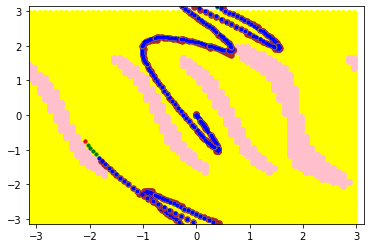

In [8]:

for envi in range(len(paths)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.set_autoscale_on(True)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    new_obs_i = []
    obs_i = obs[envi]
    for k in range(len(obs_i)):
        obs_pt = []
        obs_pt.append(obs_i[k][0]-obs_width/2)
        obs_pt.append(obs_i[k][1]-obs_width/2)
        obs_pt.append(obs_i[k][0]-obs_width/2)
        obs_pt.append(obs_i[k][1]+obs_width/2)
        obs_pt.append(obs_i[k][0]+obs_width/2)
        obs_pt.append(obs_i[k][1]+obs_width/2)
        obs_pt.append(obs_i[k][0]+obs_width/2)
        obs_pt.append(obs_i[k][1]-obs_width/2)
        new_obs_i.append(obs_pt)
    obs_i = new_obs_i

    dtheta = 0.1
    feasible_points = []
    infeasible_points = []
    imin = 0
    imax = int(2*np.pi/dtheta)


    for i in range(imin, imax):
        for j in range(imin, imax):
            x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
            if IsInCollision(x, obs_i):
                infeasible_points.append(x)
            else:
                feasible_points.append(x)
    feasible_points = np.array(feasible_points)
    infeasible_points = np.array(infeasible_points)
    print('feasible points')
    print(feasible_points)
    print('infeasible points')
    print(infeasible_points)
    ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
    ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c='pink')
    #for i in range(len(data)):
    #    update_line(hl, ax, data[i])


    
    
    #print(obs_i)
    for pathi in range(len(paths[envi])):
        start_state = sgs[envi][pathi][0]
        goal_inform_state = paths[envi][pathi][-1]
        goal_state = sgs[envi][pathi][1]
        #p = Process(target=plan_one_path, args=(obs[i], obc[i], start_state, goal_state, 500, queue))

        # propagate data
        p_start = paths[envi][pathi][0]
        detail_paths = [p_start]
        detail_controls = []
        detail_costs = []
        state = [p_start]
        control = []
        cost = []
        for k in range(len(controls[envi][pathi])):
            #state_i.append(len(detail_paths)-1)
            max_steps = int(costs[envi][pathi][k]/step_sz)
            accum_cost = 0.
            #print('p_start:')
            #print(p_start)
            #print('data:')
            #print(paths[i][j][k])
            # modify it because of small difference between data and actual propagation
            p_start = paths[envi][pathi][k]
            state[-1] = paths[envi][pathi][k]
            for step in range(1,max_steps+1):
                p_start = propagate_dynamics(p_start, controls[envi][pathi][k], step_sz)
                p_start = enforce_state_bounds(p_start)
                detail_paths.append(p_start)
                detail_controls.append(controls[envi][pathi])
                detail_costs.append(step_sz)
                accum_cost += step_sz
                if (step % 1 == 0) or (step == max_steps):
                    state.append(p_start)
                    #print('control')
                    #print(controls[i][j])
                    control.append(controls[envi][pathi][k])
                    cost.append(accum_cost)
                    accum_cost = 0.
        #print('p_start:')
        #print(p_start)
        #print('data:')
        #print(paths[i][j][-1])
        #state[-1] = paths[i][j][-1]
        data = state
        
        data = np.array(data)
        ax.scatter(data[:,0], data[:,1], c='green', s=10)
        ax.scatter(data[-1,0], data[-1,1], c='red', s=10, marker='*')
        
        
        #for start_i in range(0, len(data), num_steps):
        for start_i in range(0, len(data), num_steps):
            print("start_i: %d/%d"  % (start_i, len(data)))
            #xs, us = bvp_solve(start_state, goal_state, dt, num_steps)
            if start_i + num_steps >= len(data):
                break
                
            # initialize before solving
            x_init = np.linspace(data[start_i], data[start_i+num_steps], num_steps+1)
            
            std = 0.2
            cov = np.diag([std*bound[0], std*bound[1], std*bound[2], std*bound[3]])
            #mean = next_state
            #next_state = np.random.multivariate_normal(mean=mean,cov=cov)
            mean = np.zeros(data[start_i].shape)
            rand_x_init = np.random.multivariate_normal(mean=mean, cov=cov, size=num_steps+1)
            
            x_init = rand_x_init + x_init
            x_init[0] = data[start_i]
            x_init[-1] = data[start_i+num_steps]
            print('start:')
            print(data[start_i])
            print('goal:')
            print(data[start_i+num_steps])
            #print('x_init:')
            #print(x_init)
            u_init = np.random.uniform(-4., 4., size=(num_steps, 1))
            #print('intial xs:')
            #print(x_init)
            #print('initial us:')
            #print(u_init)
            # propagate bvp result
            p_start = x_init[0]
            detail_paths = [p_start]
            detail_controls = []
            detail_costs = []
            state = [p_start]
            control = []
            for k in range(len(u_init)):
                #state_i.append(len(detail_paths)-1)
                # modify it because of small difference between data and actual propagation
                p_start = propagate_dynamics(p_start, u_init[k], step_sz)
                p_start = enforce_state_bounds(p_start)
                detail_paths.append(p_start)
                detail_controls.append(u_init[k])
                state.append(p_start)
                #print('control')
                #print(controls[i][j])
            state = np.array(state)
            ax.scatter(state[:,0], state[:,1], c='brown', s=30)

            
            #xs, us = bvp_solve(x_init, u_init, step_sz, num_steps)
            xs, us = bvp_solve_naive(x_init, u_init, step_sz, num_steps)
            #plan_one_path(obs_i, obs[i], obc[i], start_state, goal_state, goal_inform_state, 1000, data)
            #print('optimized xs:')
            #print(xs)
            #print('optimzied us:')
            #print(us)
            ax.scatter(xs[:,0], xs[:,1], c='lightgreen', s=10)
            
            # check the optimization result loss
            """
            print('propagation to see the loss:')
            for i in range(len(xs)-1):
                x_new = propagate_dynamics(xs[i], us[i], step_sz)
                print('from: ')
                print(xs[i])
                print('to: ')
                print(x_new)
                print('predicted: ')
                print(xs[i+1])
                print(np.sum((x_new - xs[i+1]) ** 2))
            """
            
            
            # propagate bvp result
            p_start = xs[0]
            detail_paths = [p_start]
            detail_controls = []
            detail_costs = []
            state = [p_start]
            control = []
            for k in range(len(us)):
                #state_i.append(len(detail_paths)-1)
                # modify it because of small difference between data and actual propagation
                p_start = propagate_dynamics(p_start, us[k], step_sz)
                p_start = enforce_state_bounds(p_start)
                detail_paths.append(p_start)
                detail_controls.append(us[k])
                state.append(p_start)
                #print('control')
                #print(controls[i][j])
            state = np.array(state)
            ax.scatter(state[:,0], state[:,1], c='blue', s=10)
        plt.plot()